In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [7]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0


In [8]:
#group episodes to chunks
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    currentState = row['State']
    arr = [row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL']]
    if currentRUL < 1:
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
num_episodes = len(data_split)
num_episodes

668

In [10]:
num_train = int(0.75*num_episodes)
num_train

501

In [11]:
num_val = int(0.125*num_episodes)
num_val

83

In [12]:
#split into training, validation and test sets
train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [13]:
#find average episode duration 
train_episode_duration_list = []
for train_episode in train_data:
    train_episode_duration_list.append(len(train_episode))
train_episode_duration_list

[10,
 13,
 10,
 12,
 6,
 19,
 5,
 9,
 4,
 8,
 6,
 16,
 11,
 9,
 9,
 15,
 13,
 8,
 4,
 14,
 12,
 11,
 12,
 8,
 12,
 6,
 19,
 10,
 28,
 14,
 3,
 19,
 4,
 3,
 8,
 5,
 13,
 14,
 10,
 12,
 15,
 9,
 14,
 9,
 7,
 13,
 19,
 8,
 11,
 23,
 20,
 15,
 11,
 20,
 9,
 4,
 14,
 16,
 10,
 8,
 8,
 8,
 14,
 13,
 19,
 20,
 11,
 10,
 21,
 9,
 11,
 16,
 9,
 14,
 9,
 11,
 14,
 2,
 13,
 9,
 3,
 8,
 16,
 9,
 16,
 19,
 15,
 10,
 12,
 7,
 12,
 13,
 10,
 19,
 10,
 11,
 12,
 16,
 23,
 8,
 9,
 11,
 10,
 16,
 12,
 17,
 7,
 13,
 8,
 5,
 6,
 12,
 16,
 7,
 7,
 9,
 13,
 11,
 8,
 8,
 6,
 14,
 11,
 11,
 13,
 7,
 29,
 9,
 11,
 10,
 13,
 17,
 12,
 9,
 9,
 11,
 14,
 14,
 6,
 9,
 13,
 9,
 18,
 17,
 15,
 12,
 6,
 13,
 13,
 14,
 11,
 4,
 7,
 3,
 20,
 6,
 15,
 12,
 6,
 13,
 14,
 7,
 13,
 15,
 7,
 3,
 15,
 10,
 12,
 16,
 25,
 17,
 19,
 14,
 26,
 8,
 8,
 6,
 13,
 19,
 9,
 16,
 18,
 15,
 10,
 2,
 17,
 18,
 13,
 16,
 10,
 9,
 13,
 4,
 10,
 10,
 10,
 16,
 8,
 17,
 5,
 28,
 13,
 8,
 5,
 15,
 6,
 12,
 8,
 10,
 12,
 7,
 11,
 11,
 16,
 1

In [14]:
#find average
mean_episode_duration = int(sum(train_episode_duration_list)/len(train_episode_duration_list))

In [15]:
mean_episode_duration

11

In [16]:
def predictRULForTimestep(previousRUL, period, isPreviousFailure):
    newRUL = previousRUL - 1
    if (newRUL < 0) or isPreviousFailure: #update RUL to period if previous timestep failure or end of 11 timesteps 
        return period
    else:
        return newRUL

In [17]:
def predictRUL(lst, period, trueRULData):
    result = []
    prevRUL = period + 1
    isFailure = False #whether previous timestep is failure 
    for order in range(len(lst)):
        currentRUL = predictRULForTimestep(prevRUL, period, isFailure)
        result.append(currentRUL)
        prevRUL = currentRUL
        
        #check if actually failure to update the rest 
        trueRUL = trueRULData[order]
        isFailure = trueRUL < 1
        
    return result

In [18]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

Test results of baseline

In [19]:
train_data

[[[0.379151092, 0.556385187, 0.243079506, 0.229504293, 9.0],
  [0.415506993, 0.698561103, 0.242410288, 0.273824561, 8.0],
  [0.33934205, 0.637644818, 0.230266358, 0.191588098, 7.0],
  [0.343817356, 0.627731997, 0.233904513, 0.264566349, 6.0],
  [0.310361557, 0.607368113, 0.194295643, 0.240200195, 5.0],
  [0.336327636, 0.531479142, 0.215693485, 0.215780325, 4.0],
  [0.397831149, 0.57521239, 0.190585546, 0.230599092, 3.0],
  [0.385974096, 0.630933953, 0.208516333, 0.247693397, 2.0],
  [0.376943194, 0.396047283, 0.215659658, 0.256992779, 1.0],
  [0.56498231, 0.648197926, 0.516587151, 0.256162471, 0.0]],
 [[0.351867147, 0.647795783, 0.257161825, 0.276671218, 12.0],
  [0.353867353, 0.615858294, 0.197009134, 0.269388231, 11.0],
  [0.384169823, 0.622861995, 0.199791766, 0.305659257, 10.0],
  [0.353154082, 0.597895409, 0.2172971, 0.265631153, 9.0],
  [0.382126061, 0.655505276, 0.231748822, 0.258702261, 8.0],
  [0.374770865, 0.676145451, 0.243662648, 0.259956326, 7.0],
  [0.406003625, 0.6262042

In [20]:
def getDataNoEpisode(lst):
    result = []
    for episode in lst:
        for row in episode:
            row_formatted = row[:4]
            result.append(row_formatted)
    return result

In [21]:
def getRULFromDataNoEpisode(lst):
    RULresult = []
    for episode in lst:
        for row in episode:
            RULresult.append(row[4])
    return RULresult

In [22]:
#training set 
trainX = getDataNoEpisode(train_data)
trainY = getRULFromDataNoEpisode(train_data)

trainPredict = predictRUL(trainX, mean_episode_duration, trainY)
trainRMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
trainR2Score = r2_score(trainY, trainPredict)
trainSscore = findSscore(trainY, trainPredict)
print("RMSE of training set is %f, R2 score of training set is %f, S score of training set is %f" % (trainRMSE, trainR2Score, trainSscore))

RMSE of training set is 5.069402, R2 score of training set is -0.012829, S score of training set is 8868.336202


In [23]:
len(trainX)

6010

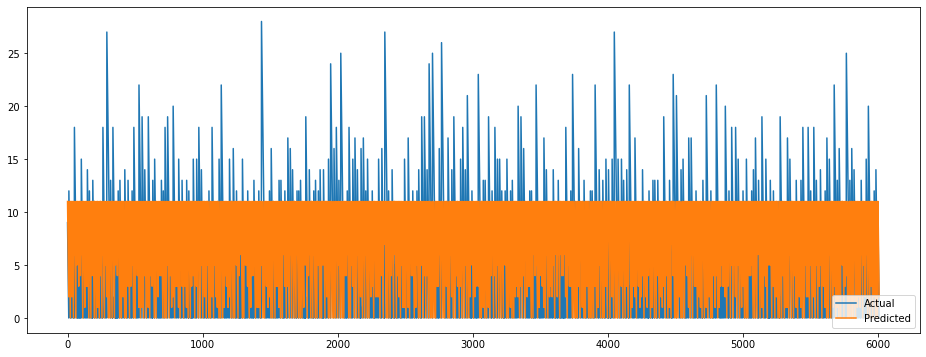

In [24]:
plt.figure(figsize=(16, 6))
plt.plot(trainY)
plt.plot(trainPredict)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

In [25]:
#validation set 
valX = getDataNoEpisode(val_data)
valY = getRULFromDataNoEpisode(val_data)

valPredict = predictRUL(valX, mean_episode_duration, valY)
valRMSE = math.sqrt(mean_squared_error(valY, valPredict))
valR2Score = r2_score(valY, valPredict)
valSscore = findSscore(valY, valPredict)
print("RMSE of validation set is %f, R2 score of validation set is %f, S score of validation set is %f" % (valRMSE, valR2Score, valSscore))

RMSE of validation set is 4.372401, R2 score of validation set is -0.048438, S score of validation set is 1377.112054


In [26]:
len(valX)

967

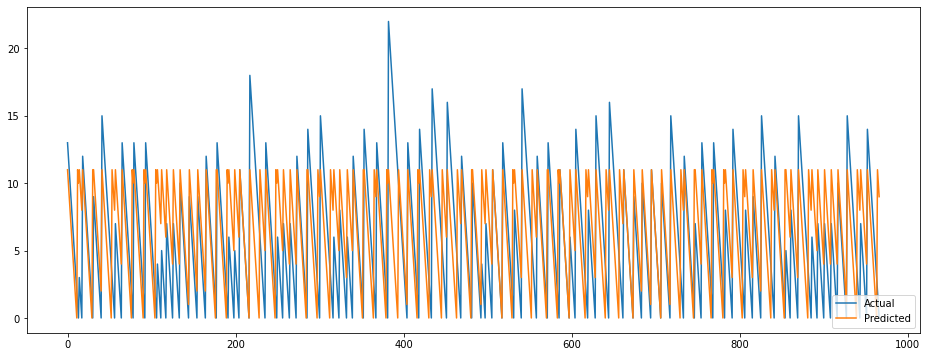

In [27]:
plt.figure(figsize=(16, 6))
plt.plot(valY)
plt.plot(valPredict)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

In [28]:
#test set 
testX = getDataNoEpisode(test_data)
testY = getRULFromDataNoEpisode(test_data)

testPredict = predictRUL(testX, mean_episode_duration, testY)
testRMSE = math.sqrt(mean_squared_error(testY, testPredict))
testR2Score = r2_score(testY, testPredict)
testSscore = findSscore(testY, testPredict)
print("RMSE of test set is %f, R2 score of test set is %f, S score of test set is %f" % (testRMSE, testR2Score, testSscore))

RMSE of test set is 4.851184, R2 score of test set is 0.016740, S score of test set is 1456.127436


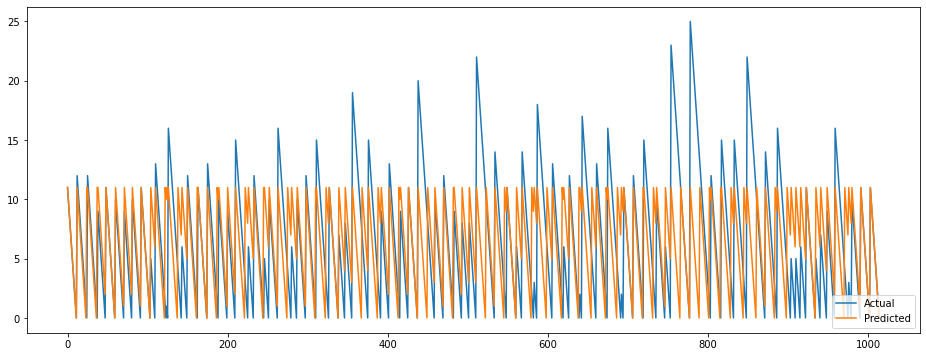

In [29]:
plt.figure(figsize=(16, 6))
plt.plot(testY)
plt.plot(testPredict)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

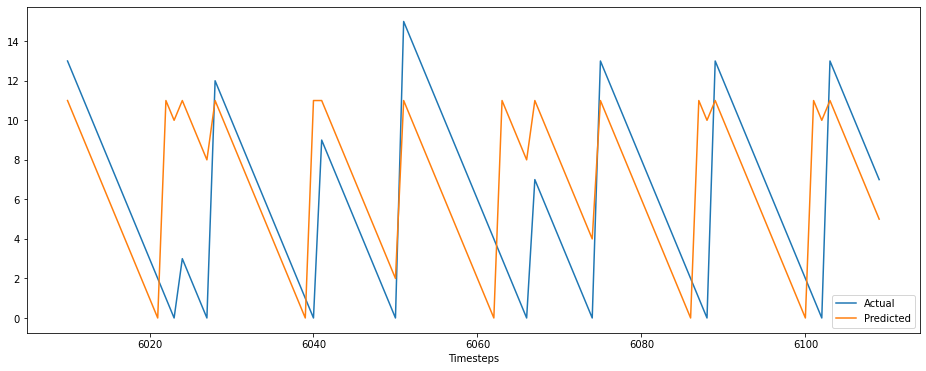

In [30]:
valTime = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(valTime[0:100], valY[0:100])
plt.plot(valTime[0:100], valPredict[0:100])
plt.xlabel('Timesteps')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

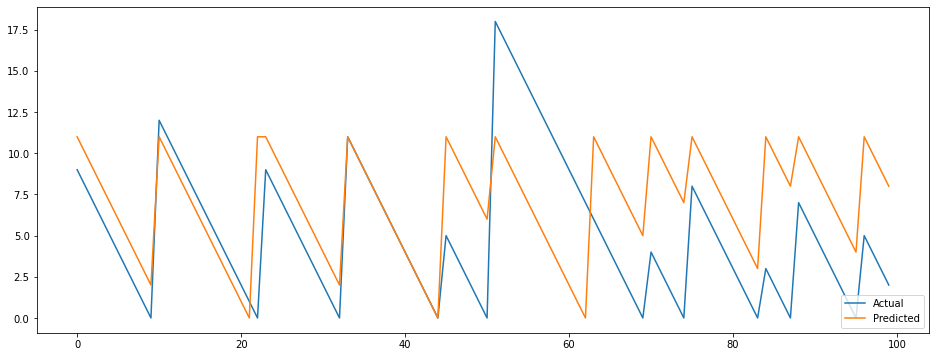

In [31]:
plt.figure(figsize=(16, 6))
plt.plot(trainY[0:100])
plt.plot(trainPredict[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()